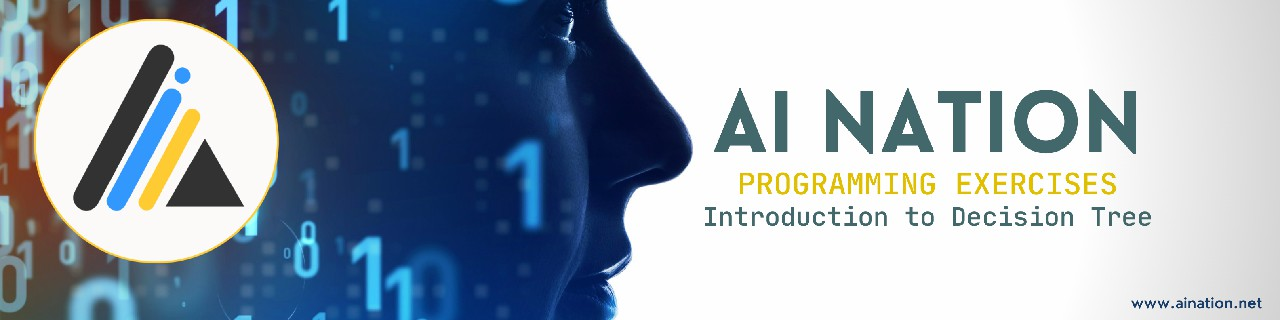

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
#!pip install sklearn

In [3]:
# loading the data set
dataset = load_iris(as_frame=True)
df= pd.DataFrame(data= dataset.data)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
# adding the target and target names to dataframe
target_zip= dict(zip(set(dataset.target), dataset.target_names))
df["target"] = dataset.target
df["target_names"] = df["target"].map(target_zip)

print(df.shape)
df.head()

(150, 6)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [9]:
# Seperating to X and Y 
X = df.iloc[:, :4]
y = df.iloc[:, -1]

In [10]:
y[:10]

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
5    setosa
6    setosa
7    setosa
8    setosa
9    setosa
Name: target_names, dtype: object

In [11]:
# splitting training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=24)

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)

print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (112, 4)
y_train shape:  (112,)
X_test shape:  (38, 4)
y_test shape:  (38,)


In [12]:
y_train[:10]

53     versicolor
58     versicolor
95     versicolor
22         setosa
15         setosa
20         setosa
69     versicolor
141     virginica
88     versicolor
37         setosa
Name: target_names, dtype: object

In [14]:
def partition(data, column, value): 
    """
    Partition the data into left (indicating True) and right (indicating false).
    
    Inputs
    data: The data to partition 
    
    Outputs
    left: index of values that meet condition
    right: index of values that fail to meet the condition
    """
    left = data[data[column] <= value].index
    right = data[data[column] > value].index

    return left, right

In [15]:
# performing a split on the root node
left_idx, right_idx = partition(X_train, "petal length (cm)", 2.45)

print("[petal length (cm) <= 2.45]")
print(left_idx.shape)
print(right_idx.shape)


[petal length (cm) <= 2.45]
(38,)
(74,)


In [16]:
# print results --> left_idx = 38 setosa | right index = 42 versicolor, 32 virginica 
print(f"left_idx: {dict(zip(np.unique(y_train.loc[left_idx], return_counts=True)[0], np.unique(y_train.loc[left_idx], return_counts=True)[1]))}\n\
right_idx: {dict(zip(np.unique(y_train.loc[right_idx],return_counts=True)[0], np.unique(y_train.loc[right_idx], return_counts=True)[1]))}")

left_idx: {'setosa': 38}
right_idx: {'versicolor': 42, 'virginica': 32}


In [17]:
#source ->  https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity

def gini_impurity(label, label_idx):
    """
    A measure of how often a randomly chosen element from the set would
    be incorrectly labelled if it was randomly labelled according to the 
    distribution of labels in the subset (Soure: Wikipedia)
    
    Inputs
    label: The class label available at current node
    
    Outputs
    impurity: The gini impurity of the node 
    """
    # the unique labels and counts in the data
    unique_label, unique_label_count = np.unique(label.loc[label_idx], return_counts=True)

    impurity = 1.0
    for i in range(len(unique_label)):
        p_i = unique_label_count[i] / sum(unique_label_count)
        impurity -= p_i ** 2 
    return impurity

In [18]:
# Gini impurity of the first node
impurity = gini_impurity(y_train, y_train.index)
impurity

0.6626275510204082

In [19]:
def information_gain(label, left_idx, right_idx, impurity): 
    """
    For each node of the tree, the information gain "represents the
    expected amount of information that would be needed to specify whether
    a new instance should be classified yes or no, given that the example
    reached that node. (Source: Wikipedia)
    
    Inputs
    left: The values that met the conditions of the current node
    right: The values that failed to meet the conditions of the current noode
    gini_impurity: the uncertainty at the current node
    
    Outputs
    info_gain: The information gain at the node
    """
    
    p = float(len(left_idx)) / (len(left_idx) + len(right_idx))
    info_gain = impurity - p * gini_impurity(label, left_idx) - (1 - p) * gini_impurity(label, right_idx)
    return info_gain

In [20]:
# testing info gain of the first split at root node
info_gain = information_gain(y_train, left_idx, right_idx, impurity)
info_gain

0.33830322669608387

In [27]:
def find_best_split(df, label, idx):
    """
    Splits the data on the best column and value 
    
    Input
    df: the training data
    label: the target label 
    idx: the index of the data
    
    Output: 
    best_gain: the max information gain
    best_col: the column that produced best information gain
    best_val: the value of the column that produced best information gain
    
    """
    
    best_gain = 0 
    best_col = None
    best_value = None
    
    df = df.loc[idx] # converting training data to pandas dataframe
    label_idx = label.loc[idx].index # getting the index of the labels

    impurity = gini_impurity(label, label_idx) # determining the impurity at the current node
    
    # go through the columns and store the unique values in each column (no point testing on the same value twice)
    for col in df.columns: 
        unique_values = set(df[col])
        # loop thorugh each value and partition the data into true (left_index) and false (right_index)
        for value in unique_values: 

            left_idx, right_idx = partition(df, col, value)
            # ignore if the index is empty (meaning there was no features that met the decision rule)
            if len(left_idx) == 0 or len(right_idx) == 0: 
                continue 
            # determine the info gain at the node
            info_gain = information_gain(label, left_idx, right_idx, impurity)
            # if the info gain is higher then our current best gain then that becomes the best gain
            if info_gain > best_gain:
                best_gain, best_col, best_value = info_gain, col, value
                
    return best_gain, best_col, best_value

In [28]:
find_best_split(X_train, y_train, y_train.index)

(0.33830322669608387, 'petal length (cm)', 1.9)

In [29]:
# helper function to count values
def count(label, idx):
    """
    Function that counts the unique values
    
    Input
    label: target labels
    idx: index of rows 
    
    Output
    dict_label_count: Dictionary of label and coun
    
    ts
    
    """
    unique_label, unique_label_counts = np.unique(label.loc[idx], return_counts=True)
    dict_label_count = dict(zip(unique_label, unique_label_counts))
    return dict_label_count
# check counts at first node to check it aligns with sci-kit learn
count(y_train, y_train.index)
{'setosa': 38, 'versicolor': 42, 'virginica': 32}

{'setosa': 38, 'versicolor': 42, 'virginica': 32}

In [30]:
#Reference source code -> 
# https://github.com/random-forests/tutorials/blob/master/decision_tree.ipynb

In [31]:
class Leaf:
    """
    A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, label, idx):
        self.predictions = count(label, idx)

In [32]:
class Decision_Node:
    """
    A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 column,
                 value,
                 true_branch,
                 false_branch):
        self.column = column
        self.value = value
        self.true_branch = true_branch
        self.false_branch = false_branch

    

In [33]:
def print_tree(node, spacing=""):
        """
        World's most elegant tree printing function.

        Input
        node: the tree node
        spacing: used to space creating tree like structure
        """

        # Base case: we've reached a leaf
        if isinstance(node, Leaf):
            print (spacing + "Predict", node.predictions)
            return

        # Print the col and value at this node
        print(spacing + f"[{node.column} <= {node.value}]")


        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        print_tree(node.true_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        print_tree(node.false_branch, spacing + "  ")

In [34]:
def build_tree(df, label, idx): 
    """
    Recursively Builds the tree until is leaf is pure. 
    
    Input 
    df: the training data
    label: the target labels
    idx: the indexes 
    
    Output
    best_col: the best column 
    best_value: the value of the column that minimizes impurity 
    true_branch: the true branch 
    false_branch: the false branch 
    """
    best_gain, best_col, best_value = find_best_split(df, label, idx)
    
    if best_gain == 0: 
        return Leaf(label, label.loc[idx].index)
    
    left_idx, right_idx = partition(df.loc[idx], best_col, best_value)
    
    true_branch = build_tree(df, label, left_idx)
    
    false_branch = build_tree(df, label, right_idx)
    
    return Decision_Node(best_col, best_value, true_branch, false_branch)

In [35]:
my_tree = build_tree(X_train, y_train, X_train.index)

In [36]:
print_tree(my_tree)

[petal length (cm) <= 1.9]
--> True:
  Predict {'setosa': 38}
--> False:
  [petal width (cm) <= 1.6]
  --> True:
    [petal length (cm) <= 4.9]
    --> True:
      Predict {'versicolor': 40}
    --> False:
      [sepal length (cm) <= 6.0]
      --> True:
        [sepal width (cm) <= 2.2]
        --> True:
          Predict {'virginica': 1}
        --> False:
          Predict {'versicolor': 1}
      --> False:
        Predict {'virginica': 2}
  --> False:
    [petal length (cm) <= 4.8]
    --> True:
      [sepal width (cm) <= 3.0]
      --> True:
        Predict {'virginica': 3}
      --> False:
        Predict {'versicolor': 1}
    --> False:
      Predict {'virginica': 26}


In [24]:
def predict(test_data, tree):
    
    """
    Classify unseen examples
    
    Inputs
    test_data: Unseen observation
    tree: tree that has been trained on training data
    
    Output
    The prediction of the observation.
    """
    
    # Check if we are at a leaf node
    if isinstance(tree, Leaf): 
        return max(tree.predictions)
    
    # the current feature_name and value 
    feature_name, feature_value = tree.column, tree.value
    
    # pass the observation through the nodes recursively
    if test_data[feature_name] <= feature_value: 
        return predict(test_data, tree.true_branch)
    
    else: 
        return predict(test_data, tree.false_branch)

In [25]:
# taking one instance to test function 
example, example_target = X_test.iloc[6], y_test.iloc[6]
example, example_target

(sepal length (cm)    5.3
 sepal width (cm)     3.7
 petal length (cm)    1.5
 petal width (cm)     0.2
 Name: 48, dtype: float64,
 'setosa')

In [26]:
# if working correctly should output setosa
predict(example, my_tree)

NameError: name 'my_tree' is not defined

In [28]:
# create a new col of predictions
X_test["predictions"] = X_test.apply(predict, axis=1, args=(my_tree,))

<ipython-input-28-0165600acfcf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["predictions"] = X_test.apply(predict, axis=1, args=(my_tree,))


In [32]:
print("My Implementation:\nACCURACY: {}".format(accuracy_score(y_test, X_test['predictions'])))

My Implementation:
ACCURACY: 0.9736842105263158
